In [ ]:
#from torchviz import make_dot, make_dot_from_trace

In [1]:
from graphviz import Digraph
import torch
from torch.autograd import Variable

In [2]:
def resize_graph(dot, size_per_element=0.15, min_size=12):
    """Resize the graph according to how much content it contains.
    Modify the graph in place.
    """
    # Get the approximate number of nodes and edges
    num_rows = len(dot.body)
    content_size = num_rows * size_per_element
    size = max(min_size, content_size)
    size_str = str(size) + "," + str(size)
    dot.graph_attr.update(size=size_str)

In [16]:

def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph.
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert all(isinstance(p, torch.Tensor) for p in params.values())
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '(' + (', ').join(['%d' % v for v in size]) + ')'

    output_nodes = (var.grad_fn,) if not isinstance(var, tuple) else tuple(v.grad_fn for v in var)

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                print('HOHOHOHOHOHOHOHOHOHOOHO')
                # note: this used to show .saved_tensors in pytorch0.2, but stopped
                # working as it was moved to ATen and Variable-Tensor merged
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
                raise
            elif hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            elif var in output_nodes:
                dot.node(str(id(var)), str(type(var).__name__), fillcolor='darkolivegreen1')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)

    # handle multiple outputs
    if isinstance(var, tuple):
        for v in var:
            add_nodes(v.grad_fn)
    else:
        add_nodes(var.grad_fn)

    resize_graph(dot)

    return dot

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import torch
import torchvision

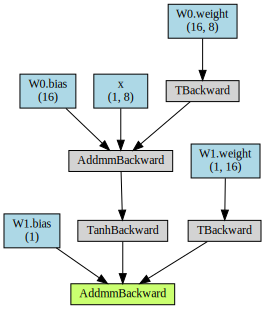

In [17]:
import collections

model = torch.nn.Sequential()
model.add_module('W0', torch.nn.Linear(8, 16))
model.add_module('tanh', torch.nn.Tanh())
model.add_module('W1', torch.nn.Linear(16, 1))

x = torch.randn(1,8)
x.requires_grad_(True)

params = dict(model.named_parameters())
params['x'] = x

#make_dot(model(x)), params=)
make_dot(model(x), params=params)

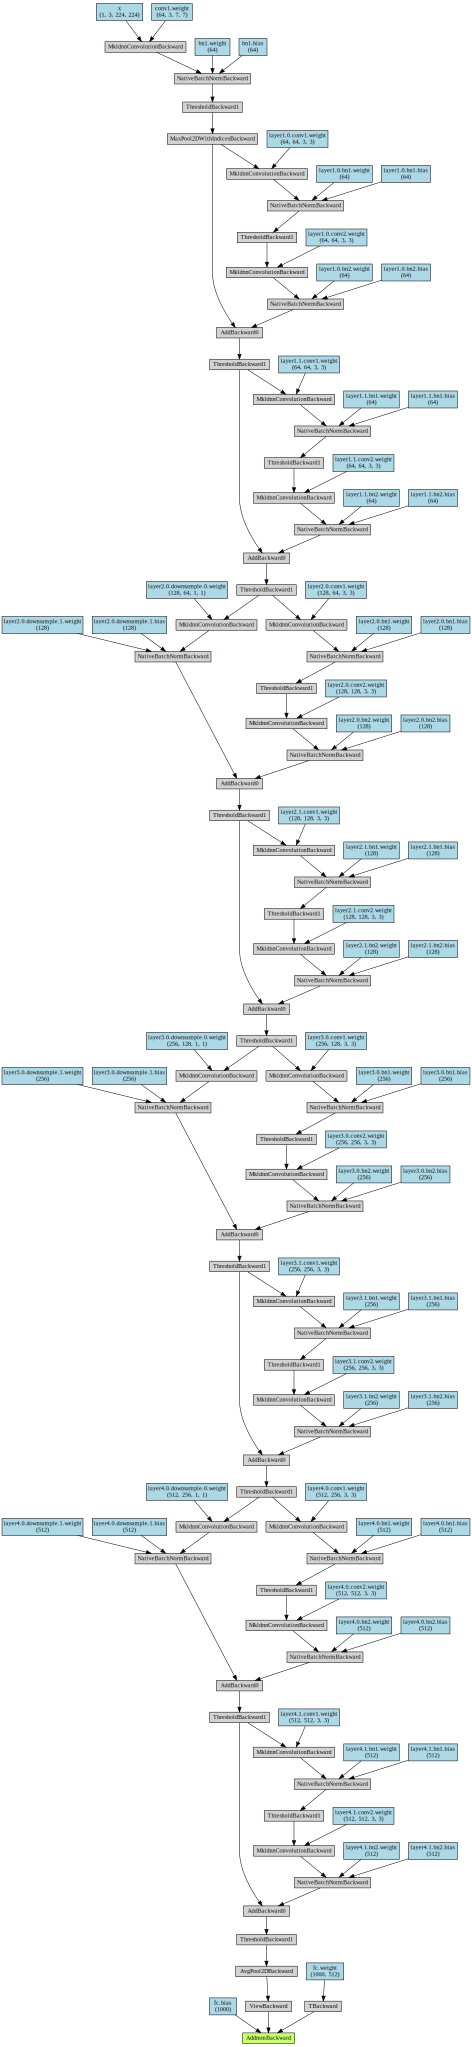

In [23]:
resnet18 = torchvision.models.resnet18()
params = dict(resnet18.named_parameters())

x = torch.randn(1,3,224,224, requires_grad=True)
params['x'] = x

make_dot(resnet18(x), params=params)

# Deconv Test

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
x = torch.tensor([[[[1, 1], [1, 1]]]], dtype=torch.float32)
x.shape

torch.Size([1, 1, 2, 2])

In [39]:
w = torch.randn([1, 32, 2, 2])

In [35]:
model = nn.Sequential(
    nn.ConvTranspose2d(in_channels=1, out_channels=32, kernel_size=2, stride=2, padding=0)
)

In [42]:
F.conv_transpose2d(x, w, stride=2, padding=0)[0][0]

tensor([[ 0.7618,  0.4847,  0.7618,  0.4847],
        [ 1.8091, -0.2932,  1.8091, -0.2932],
        [ 0.7618,  0.4847,  0.7618,  0.4847],
        [ 1.8091, -0.2932,  1.8091, -0.2932]])

In [43]:
F.conv_transpose2d(x, w, stride=2, padding=1)[0][0]

tensor([[-0.2932,  1.8091],
        [ 0.4847,  0.7618]])

In [38]:
model[0].weight.shape

torch.Size([1, 32, 2, 2])

In [36]:
model(x)[0][0]

tensor([[-0.0228, -0.0123, -0.0228, -0.0123],
        [ 0.0731,  0.0708,  0.0731,  0.0708],
        [-0.0228, -0.0123, -0.0228, -0.0123],
        [ 0.0731,  0.0708,  0.0731,  0.0708]], grad_fn=<SelectBackward>)

# Autograd Test

In [190]:
x = torch.tensor([[2.]], requires_grad=True)
x

tensor([[2.]], requires_grad=True)

In [178]:
w = torch.tensor([[3.0]], requires_grad=True)
w

tensor([[3.]], requires_grad=True)

In [179]:
b = torch.tensor([[1.0]], requires_grad=True)
b

tensor([[1.]], requires_grad=True)

In [191]:
y = w @ x + b

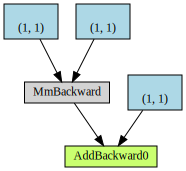

In [192]:
make_dot(y)

In [195]:
w.grad

tensor([[4.]])

In [194]:
y.backward()

In [ ]:
w.zero_()

In [119]:
lin = torch.nn.Linear(3, 2, bias=False)

In [121]:
lin.weight

Parameter containing:
tensor([[-0.5446, -0.5565,  0.5250],
        [-0.0558, -0.3211, -0.1788]], requires_grad=True)

In [304]:
F.softmax(x)

/home/marcin/.anaconda/envs/ptgpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[1.]], grad_fn=<SoftmaxBackward>)

# Neural Network Test

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [38]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.lin1 = nn.Linear(2, 8)
        self.lin2 = nn.Linear(8, 1)
    def forward(self, x):
        h = F.relu(self.lin1(x))
        y = torch.sigmoid(self.lin2(h))
        return y

In [39]:
net = MyNet()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [44]:
input = torch.randn(1, 2)
target = torch.tensor([0.0])

In [45]:
output = net(input)
loss = criterion(output, target)

In [46]:
learning_rate = 0.1
net.zero_grad()
loss.backward()
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [47]:
# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

In [48]:
net.state_dict()

OrderedDict([('lin1.weight', tensor([[ 0.4794, -0.2438],
                      [-0.6113,  0.2007],
                      [-0.1760, -0.0506],
                      [ 0.4440,  0.5615],
                      [-0.4094, -0.0372],
                      [ 0.2702, -0.4637],
                      [ 0.2868,  0.1638],
                      [ 0.1127, -0.6025]])),
             ('lin1.bias',
              tensor([ 0.3046, -0.4695, -0.3253,  0.3803,  0.4973, -0.4321,  0.3703, -0.0249])),
             ('lin2.weight',
              tensor([[ 0.2276,  0.1921, -0.0404,  0.1374, -0.1153,  0.2547,  0.0200,  0.0071]])),
             ('lin2.bias', tensor([-0.2930]))])

Save model

In [50]:
# Save model
torch.save(net.state_dict(), 'checkpoint.pth')

# Load to existing model
state_dict = torch.load('checkpoint.pth')
net.load_state_dict(state_dict)

# LogSoftmax Test

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [26]:
logits = torch.tensor([[0., 1, 2, 3]])
logits

tensor([[0., 1., 2., 3.]])

In [30]:
targets = torch.tensor([2])
targets

tensor([2])

In [31]:
logsm = F.log_softmax(logits, dim=-1)
logsm

tensor([[-3.4402, -2.4402, -1.4402, -0.4402]])

In [32]:
F.nll_loss(logsm, targets)

tensor(1.4402)

In [33]:
F.cross_entropy(logits, targets)

tensor(1.4402)

In [35]:
sm = F.softmax(logits, dim=-1)

In [36]:
F.

tensor([[0.0321, 0.0871, 0.2369, 0.6439]])